Indirect realization of measurement-based quantum feedback by the delayed-measurement method

In [1]:
from quafu import User
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
user = User("<Your token>")
user.save_apitoken()

In [2]:
available_backends = user.get_available_backends()

system_name	 qubits	 status
ScQ-P10   	 10   	 Obsolete
ScQ-P18   	 18   	 Obsolete
Baiwang   	 136  	 Obsolete
ScQ-P102  	 102  	 Obsolete
ScQ-Sim10 	 10   	 Online
Miaofeng  	 108  	 Maintenance
Dongling  	 105  	 Online
Haituo    	 105  	 Offline
Baihua    	 110  	 Offline
Yunmeng   	 156  	 Obsolete
Xiang     	 35   	 Obsolete
ScQ-P21test	 2    	 Obsolete
ScQ-P21   	 9    	 Maintenance
ScQ-Sim   	 2    	 Offline


In [3]:
import numpy as np
from quafu import QuantumCircuit

During a gate-based quantum computing process, some quantum gates may be controlled by measurement results of other qubits. This is usually called measurement-based quantum feedback. Currently, this operation is available in pyquafu, but not supported by the real Quafu quantum processors yet.

Luckily, there are several methods to realize measurement-based quantum feedback indirectly. In this demo, we will show one of the methods to equivalently perform measurement-based quantum feedback. We call this method the delayed-measurement method.

Imagine a system of two qubits $Q_C$ and $Q_T$, and a unitary quantum logic gate $A$. The basic idea of the delayed-measurement method comes from the equivality of the two processes:

(1) Measuring $Q_C$ and obtain the result $s$. If $s=1$, perform the gate $A$ on $Q_T$.

(2) Performing a controlled-$A$ gate between $Q_C$ and $Q_T$:

$U_{CA}=\ket{0}_C\bra{0}_C\otimes I_T+\ket{1}_C\bra{1}_C\otimes A_T$,

and measure $Q_C$.

It is obvious that the first condition is a typical measurement-based quantum feedback. Thus, the measurement-based quantum feedback can be indirectly realized by replacing the single-qubit gate $A$ with a controlled-$A$ gate between the control qubit and the target qubit, and delaying the measurement of the control qubit to the end of the process.

Now, as an example, we consider a quantum circuit for quantum teleportation, which requires measurement-based quantum feedback:

In [4]:
qc1 = QuantumCircuit(3)

#Initialization

#Input. The input here is set to the |1> state.

qc1.x(0)

#Preparation of other qubits. Note that here we use an equivalent circuit of Bell gate, which is implemented in PRA 97, 032320 (2018).

qc1.z(1)
qc1.h(2)
qc1.cz(1, 2)
qc1.h(1)
qc1.cz(1, 2)
qc1.h(2)

#Main process

qc1.cx(0, 1)
qc1.h(0)

qc1.measure([0, 1],  [0, 1])

qc1.x(2).cif([1], 1)
qc1.z(2).cif([0], 1)

# Obtaining the final result

qc1.measure([2],  [2])

Although we can test this circuit on the QASM simulator, it is yet unavailable on any real Quafu device.

Next, we modify the above circuit with the delayed-measurement approach:

In [5]:
qc2 = QuantumCircuit(3)

#Initialization

#Input
qc2.x(0)

#Preparation of other qubits.

qc2.z(1)
qc2.h(2)
qc2.cz(1, 2)
qc2.h(1)
qc2.cz(1, 2)
qc2.h(2)

#Main process

qc2.cx(0, 1)
qc2.h(0)

qc2.cx(1, 2)
qc2.cz(0, 2)

measures0 = [0, 1]
cbits0 = [0, 1]
qc2.measure(measures0,  cbits=cbits0)

# Obtaining the final result
measures2 = [2]
cbits2 = [2]
qc2.measure(measures2,  cbits=cbits2)

In [6]:
#qc2.plot_circuit()

All the operations mentioned in this circuit are supported by the real Quafu devices. Thus, we can directly perform this circuit using the real devices.

Now, we firstly run both the two circuits using the QASM simulator:

{'000': 25, '011': 33, '100': 21, '111': 21}


<BarContainer object of 4 artists>

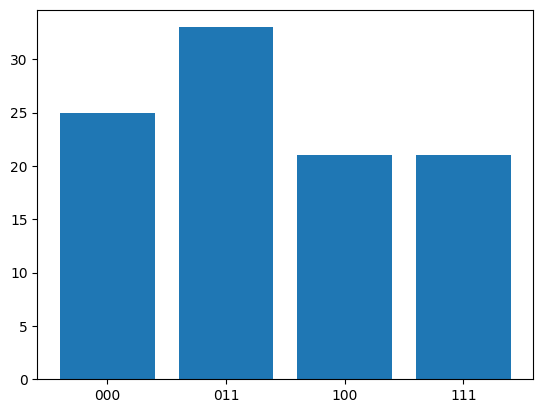

In [7]:
from quafu import Task
from quafu import simulate
simu_res1 = simulate(qc1)
counts = simu_res1.counts
#simu_res1.plot_probabilities()
print(counts)

names = list(counts.keys())
values = list(counts.values())

plt.bar(range(len(counts)), values, tick_label=names)

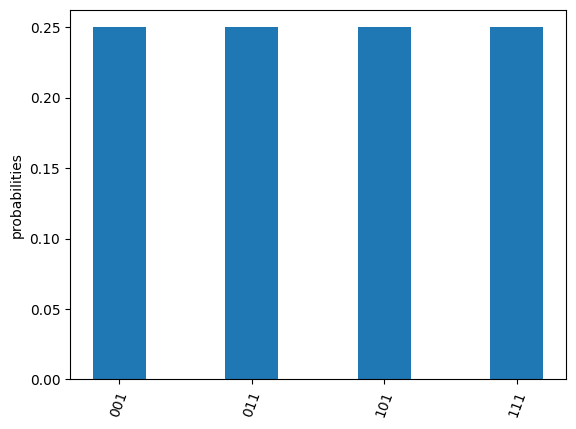

In [8]:
simu_res2 = simulate(qc2)
simu_res2.plot_probabilities()

Although yet we cannot strictly prove the equivalency of the two circuits via quantum process tomography, it is by and large clear that the delayed-measurement approach can indirectly realize measurement-based quantum feedback -- and it can be realized directly on the real Quafu devices, without any improvement on the hardware.

Now, we perform the delayed-measurement circuit using a real Quafu device:

In [9]:
task = Task()

In [10]:
task.config(backend="Dongling", shots=10000, compile=True)

In [11]:
res = task.send(qc2, wait=True)

In [12]:
print(res.probabilities) #probabilities

{'000': 0.0738, '001': 0.1929, '010': 0.0742, '011': 0.1829, '100': 0.0839, '101': 0.1701, '110': 0.0616, '111': 0.1606}


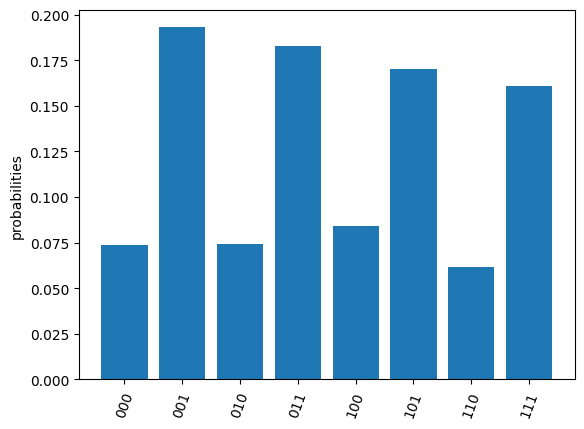

In [13]:
res.plot_probabilities()

The results obtained from the real Quafu device also proves the effectiveness of the delayed-measurement method.

Before the end of this demo, we would like to note that, the delayed measurement in the delayed-measurement approach does not impact the result of the quantum computing process. Thus, the delayed-measurement approach not only provides us an indirect way to perform measurement-based quantum feedback, but also behaves robust against quantum measurement error.